# Mutual information analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [2]:
from jpype import *

#start JVM by telling where the java path and the jar file you want to use are
if isJVMStarted() == False:
    jarLocation = f'Java Development Kit\infodynamics.jar' #path to infodynamics.jar
    jvmPath = f'C:\\Program Files\\Java\\jdk-22\\bin\\server\\jvm.dll' #path to JVM.dll
    startJVM(jvmPath, "-ea", "-Djava.class.path=" + jarLocation)

In [3]:
implementingClass = "infodynamics.measures.continuous.kraskov.MutualInfoCalculatorMultiVariateKraskov1"

indexOfLastDot = implementingClass.rfind(".")
implementingPackage = implementingClass[:indexOfLastDot]
implementingBaseName = implementingClass[indexOfLastDot+1:]
miCalcClass = eval('JPackage(\'%s\').%s' % (implementingPackage, implementingBaseName))
miCalc = miCalcClass()


In [ ]:
stocks = ['ALV.DE', 'BRK-B', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'JPM', 'MSFT', 'NESN.SW', 'NVDA', 'TSLA', 'WIX']
names = ['Allianz', 'Berkshire Hathaway', 'Bitcoin', 'Dogecoin', 'Ethereum', 'JP Morgan', 'Microsoft', 'Nestle', 'Nvidia', 'Tesla', 'Wix.com']
labels = ['Google Trends Score', 'GDELT Article Volume', 'GDELT Sentiment Score', 'Trading Volume']

miStat = np.zeros((len(labels), len(labels)))
miP = np.zeros((len(labels), len(labels)))


for i, stock in enumerate(stocks):
    print("calculating mutual information for", stock)
    name = names[i]
    df = pd.read_csv(f'data/{stock}.csv', comment='#', index_col=0)
    gtrends = df['Google Trends Score ' + name].to_numpy()
    article = df['GDELT Article Volume'].to_numpy()
    trading = df[stock + ' Trading Volume'].to_numpy()
    sentiment = df['GDELT Sentiment Score'].to_numpy()

    data = np.array([gtrends, article, sentiment, trading])

    # mutual information
    for i, column1 in enumerate(labels):
        for j, column2 in enumerate(labels):
            if column1 != column2:
                print("-- currently:", column1, "->", column2)
                miCalc.initialise(1, 1)
                miCalc.setObservations(data[i], data[j])
                miStat[i][j] += miCalc.computeAverageLocalOfObservations()
                miP[i][j] += miCalc.computeSignificance(1000).pValue
            else:
                miStat[i][j] = np.NaN
                miP[i][j] = np.NaN

miStat = miStat / len(stocks)
miP = miP / len(stocks)

In [6]:
#save the mutual information matrix and the p-value matrix in the folder 'attentionProxies_npdata'
# np.save('attentionProxies_npdata/miStat.npy', miStat)
# np.save('attentionProxies_npdata/miP.npy', miP)

#load the mutual information matrix and the p-value matrix from the folder 'attentionProxies_npdata'
miStat = np.load('data/attentionProxies_npdata/miStat.npy')
miP = np.load('data/attentionProxies_npdata/miP.npy')


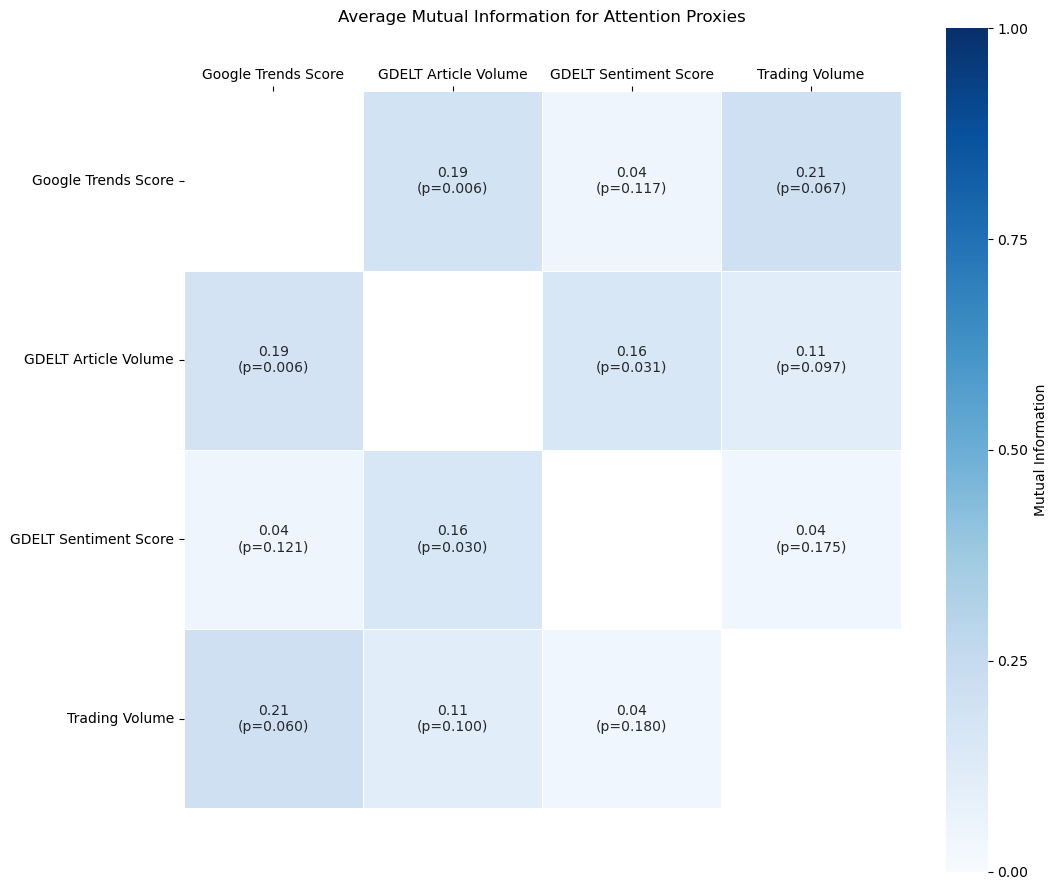

In [7]:
# Define a custom color palette
# num_bins = 100
# blue_gradient = sns.color_palette("Blues",  num_bins)
# blue_gradient.insert(0, (1, 1, 1))  # insert white at the beginning for -0.1
# custom_cmap_visible = LinearSegmentedColormap.from_list('custom_blue', blue_gradient, N=num_bins)
norm = Normalize(vmin=0, vmax=1)  # Normalizing from 0 to 1

# Define precision variables
prec1 = 2
prec2 = 3

annot = np.zeros((len(labels), len(labels)), dtype=object)

# Define the matrix with format placeholders
for i in range(len(labels)):
    for j in range(len(labels)):
        if i == j:
            annot[i][j] = ''
        else:
            annot[i][j] = '{:.{prec1}f}\n(p={:.{prec2}f})'.format(miStat[i][j], miP[i][j], prec1=prec1, prec2=prec2)

# Plot the heatmap
plt.figure(figsize=(11, 9))
heatmap = sns.heatmap(miStat, annot=annot, fmt='', cmap="Blues", norm=norm, cbar_kws={"ticks": np.linspace(0, 1, 5), 'label': 'Mutual Information'}, linewidths=.5, square=True)

plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
heatmap.xaxis.tick_top()
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=10)
plt.tight_layout()
plt.title('Average Mutual Information for Attention Proxies', pad=50)
plt.savefig('img/attention_proxies/mutual_information.png')
plt.show()


In [8]:
stocks = ['ALV.DE', 'BRK-B', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'JPM', 'MSFT', 'NESN.SW', 'NVDA', 'TSLA', 'WIX']
names = ['Allianz', 'Berkshire Hathaway', 'Bitcoin', 'Dogecoin', 'Ethereum', 'JP Morgan', 'Microsoft', 'Nestle', 'Nvidia', 'Tesla', 'Wix.com']
labels = ['Price (Open)', 'Price (Close)', 'Google Trends Score', 'GDELT Article Volume', 'GDELT Sentiment Score', 'Trading Volume']
xlabels = ['Price (Open)', 'Price (Close)', 'Google\nTrends Score', 'GDELT\nArticle Volume', 'GDELT\nSentiment Score', 'Trading Volume']

miStat = np.zeros((len(labels), len(labels)))
miP = np.zeros((len(labels), len(labels)))


for i, stock in enumerate(stocks):
    print("calculating mutual information for", stock)
    name = names[i]
    df = pd.read_csv(f'data/{stock}.csv', comment='#', index_col=0)
    priceO = df[stock + ' (Open)'].to_numpy()
    priceC = df[stock + ' (Close)'].to_numpy()
    gtrends = df['Google Trends Score ' + name].to_numpy()
    article = df['GDELT Article Volume'].to_numpy()
    sentiment = df['GDELT Sentiment Score'].to_numpy()
    trading = df[stock + ' Trading Volume'].to_numpy()

    data = np.array([priceO, priceC, gtrends, article, sentiment, trading])

    # mutual information
    for i, column1 in enumerate(labels):
        for j, column2 in enumerate(labels):
            if column1 != column2:
                print("-- currently:", column1, "->", column2)
                miCalc.initialise(1, 1)
                miCalc.setObservations(data[i], data[j])
                miStat[i][j] = miCalc.computeAverageLocalOfObservations()
                miP[i][j] = miCalc.computeSignificance(1000).pValue
            else:
                miStat[i][j] = np.NaN
                miP[i][j] = np.NaN

    norm = Normalize(vmin=0, vmax=1)  # Normalizing from 0 to 1

    # Define precision variables
    prec1 = 2
    prec2 = 3

    annot = np.zeros((len(labels), len(labels)), dtype=object)

    # Define the matrix with format placeholders
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                annot[i][j] = ''
            else:
                annot[i][j] = '{:.{prec1}f}\n(p={:.{prec2}f})'.format(miStat[i][j], miP[i][j], prec1=prec1, prec2=prec2)

    # Plot the heatmap
    plt.figure(figsize=(11, 9))
    heatmap = sns.heatmap(miStat, annot=annot, fmt='', cmap="Blues", norm=norm, cbar_kws={"ticks": np.linspace(0, 1, 5), 'label': 'Mutual Information'}, linewidths=.5, square=True)

    plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=xlabels, rotation=0)
    plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
    heatmap.xaxis.tick_top()
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=10)
    plt.tight_layout()
    plt.title('Mutual Information for Attention Proxies: ' + str(name), pad=50)
    plt.savefig('img/attention_proxies/individual/mutual_information_' + str(stock) + '.png')
    plt.close()
    # plt.show()


calculating mutual information for ALV.DE
-- currently: Price (Open) -> Price (Close)
-- currently: Price (Open) -> Google Trends Score
-- currently: Price (Open) -> GDELT Article Volume
-- currently: Price (Open) -> GDELT Sentiment Score
-- currently: Price (Open) -> Trading Volume
-- currently: Price (Close) -> Price (Open)
-- currently: Price (Close) -> Google Trends Score
-- currently: Price (Close) -> GDELT Article Volume
-- currently: Price (Close) -> GDELT Sentiment Score
-- currently: Price (Close) -> Trading Volume
-- currently: Google Trends Score -> Price (Open)
-- currently: Google Trends Score -> Price (Close)
-- currently: Google Trends Score -> GDELT Article Volume
-- currently: Google Trends Score -> GDELT Sentiment Score
-- currently: Google Trends Score -> Trading Volume
-- currently: GDELT Article Volume -> Price (Open)
-- currently: GDELT Article Volume -> Price (Close)
-- currently: GDELT Article Volume -> Google Trends Score
-- currently: GDELT Article Volume -> G